In [1]:
!git clone https://github.com/sriyash421/CycleGAN.git
import tqdm
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F_
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torch.utils.data import Dataset, DataLoader

fatal: destination path 'CycleGAN' already exists and is not an empty directory.


In [0]:
class dataset(Dataset):
    def __init__(self):
        image_size = 256
        self.datasetA = list(torchvision.datasets.ImageFolder(root='CycleGAN/datasets/horse2zebra/horses',
                                                        transform=transforms.Compose([transforms.Resize(image_size),
                                                        transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])))
        self.datasetB = list(torchvision.datasets.ImageFolder(root='CycleGAN/datasets/horse2zebra/zebras',
                                                        transform=transforms.Compose([transforms.Resize(image_size),
                                                        transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])))
        self.max_length = max(len(self.datasetA),len(self.datasetB))
        if self.max_length == len(self.datasetA):
            self.datasetB.extend(random.sample(self.datasetB, len(self.datasetB))
                                 [:self.max_length-len(self.datasetB)])
        elif self.max_length == len(self.datasetB):
            self.datasetA.extend(random.sample(self.datasetA, len(self.datasetA))
                                 [:self.max_length-len(self.datasetA)])
    
    def __len__(self):
        return self.max_length
    
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
        

In [0]:
dataloader = DataLoader(dataset(), batch_size=1, shuffle=True, num_workers=5)

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else 'cpu')
print(device)
pool_size = 50

cuda:0


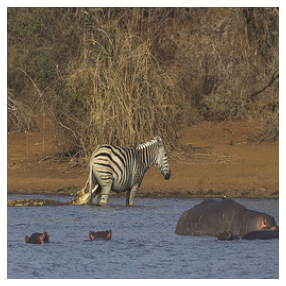

In [5]:
real_batch = next(iter(dataloader))[1]
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
class ResidualBlock(nn.Module):
        def __init__(self, in_c=256, out_c=256, k=3):
            super(ResidualBlock, self).__init__()
            self.model = nn.Sequential(
                nn.ReflectionPad2d(int(k/2)),
                nn.Conv2d(in_c, out_c, kernel_size=k),
                nn.ReLU(True),
                nn.ReflectionPad2d(int(k/2)),
                nn.Conv2d(out_c, out_c, kernel_size=k),
                nn.ReLU(True)
            )
            self.relu = nn.ReLU()
        
        def forward(self, x):
            residual = x
            x = self.model(x)
            return (x+residual)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        temp = [ResidualBlock() for i in range(6)]
        self.residual_block = nn.Sequential(*temp)
        self.model = nn.Sequential(
            self.get_conv_block(3, 64),
            self.get_conv_block(64, 128, k=3, s=2),
            self.get_conv_block(128, 256, k=3, s=2),
            self.residual_block,
            self.get_conv_t_block(256, 128),
            self.get_conv_t_block(128, 64),
            self.get_conv_block(64, 3),
            nn.Tanh()
        )
    
    def get_conv_block(self, in_c, out_c, k=7, s=1):
        return nn.Sequential(
            nn.ReflectionPad2d(int(k/2)),
            nn.Conv2d(in_c, out_c, kernel_size=k, stride=s),
            nn.InstanceNorm2d(in_c),
            nn.ReLU(True),
        )
    
    def get_conv_t_block(self, in_c, out_c, k=3, s=2):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=1, output_padding=1),
            nn.InstanceNorm2d(in_c),
            nn.ReLU(True),
        )
    
    # def normalise(self, X):
    #     batch_size = X.shape[0]
    #     img_size = X.shape[-1]
    #     X = X.view(batch_size, 3, -1)
    #     min_x, max_x = torch.min(X, dim=2)[0].unsqueeze(2), torch.max(X, dim=2)[0].unsqueeze(2)
    #     X = (X-min_x)/(max_x-min_x+1e-8)
    #     X = X.view(batch_size, 3, img_size, -1)
    #     return X

    
    def forward(self, x):
        # return self.normalise(self.model(x))
        return self.model(X)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            self.get_conv_block(3, 64),
            self.get_conv_block(64, 128, norm=nn.InstanceNorm2d(128)),
            self.get_conv_block(128, 256, norm=nn.InstanceNorm2d(256)),
            self.get_conv_block(256, 512, norm=nn.InstanceNorm2d(512)),
            nn.Conv2d(512, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def get_conv_block(self, in_c, out_c, k=4, s=2, p=1,  norm=nn.Identity()):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p),
            norm,
            nn.LeakyReLU(True, 0.2)
        )
        
    
    def forward(self, x):
        return self.model(x)

In [0]:
def weights_init(m) :
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [0]:
lr = 0.0002
num_epochs = 100
def get_generator(lr=lr, b1=0.5, b2=0.999):
    model = Generator().to(device)
    model.apply(weights_init)
    opt = optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
    return model, opt

def get_discriminator(lr=lr, b1=0.5, b2=0.999):
    model = Discriminator().to(device)
    model.apply(weights_init)
    opt = optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
    return model, opt

In [0]:
#F: X->Y
F, optF = get_generator()
#G: Y->X
G, optG = get_generator()
#D_X: verifies X
D_X, optX = get_discriminator()
#D_Y: verifies Y
D_Y, optY = get_discriminator()

In [0]:
GANLoss = nn.MSELoss()

def get_loss(model, X, label):
    output = model(X)
    output = output.view(X.shape[0],-1).mean(1, keepdims=True).squeeze(1)
    Y = torch.full((output.shape[0], ),label, device=device).detach()
    loss = GANLoss(output, Y)
    return loss

def get_cycle_loss(X, Y):
    loss = torch.abs(X-Y).mean()
    accuracy = (torch.abs(X-Y)<0.002).float().mean()
    return loss, accuracy
  
def get_fake(image, fake_pool) :
    if len(fake_pool) < pool_size :
        fake_pool.append(image)
        return image
    else :
        p = random.random()
        if p > 0.5:
            random_id = random.randint(0,pool_size-1)
            temp = fake_pool[random_id]
            fake_pool[random_id] = image
            return temp
        else :
            return image

In [0]:
def show_images(images):
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
lambda_ = lambda x : x - (lr/num_epochs)
schedulerF = optim.lr_scheduler.LambdaLR(optF, lr_lambda=lambda_)
schedulerG = optim.lr_scheduler.LambdaLR(optG, lr_lambda=lambda_)
schedulerY = optim.lr_scheduler.LambdaLR(optY, lr_lambda=lambda_)
schedulerX = optim.lr_scheduler.LambdaLR(optX, lr_lambda=lambda_)
G_losses = []
F_losses = []
accuracies = []

  0%|          | 0/200 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


--------------------------
Epoch: 0 
errF = 0.3113962411880493 
errDY = 0.5340307354927063 
errG = 0.22352908551692963 
errDX = 0.5340307354927063
CycleLoss = 1.098038911819458
per_pix_acc = 0.0010121663799509406
--------------------------


  0%|          | 0/200 [00:07<?, ?it/s]


RuntimeError: ignored

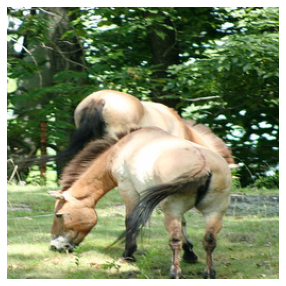

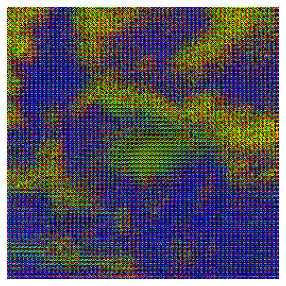

In [15]:
fake_pool_X = []
fake_pool_Y = []
F.train()
G.train()
D_X.train()
D_Y.train()
for epoch in tqdm.trange(num_epochs*2) :
    show=True
    for i, (X, Y) in enumerate(dataloader) :
        optX.zero_grad()
        optY.zero_grad()
        optF.zero_grad()
        optG.zero_grad()
        
        X = torch.FloatTensor(X[0]).to(device) #real X
        Y = torch.FloatTensor(Y[0]).to(device) #real Y
        
        Y_ = F(X)  #fake Y
        X_ = G(Y)  #fake X
        
        rec_X = G(Y_)
        rec_Y = F(X_)
        
        errD_X = get_loss(D_X, X, 1)+get_loss(D_X, get_fake(X_, fake_pool_X).detach(), 0)
        errD_Y = get_loss(D_Y, Y, 1)+get_loss(D_Y, get_fake(Y_, fake_pool_Y).detach(), 0)
        
        D_loss = (errD_X+errD_Y)*0.5
        
        D_loss.backward(retain_graph=True)
        optX.step()
        optY.step()
        
        errF = get_loss(D_Y, Y_, 0)
        errG = get_loss(D_X, X_, 0)
        cycle_lossX, accuracyX = get_cycle_loss(X, rec_X)
        cycle_lossY, accuracyY = get_cycle_loss(Y, rec_Y)
        cycle_loss = cycle_lossX+cycle_lossY
        accuracy = (accuracyX+accuracyY)/2.0                 
        identity_lossX, _ = get_cycle_loss(X, G(X))
        identity_lossY, _ = get_cycle_loss(Y, F(Y))
        
        G_loss = errF+errG+10*(cycle_lossX+cycle_lossY)+(identity_lossX+identity_lossY)
        
        G_loss.backward(retain_graph=True)
        optF.step()
        optG.step()
                
        F_losses.append((errF, errD_Y))
        G_losses.append((errG, errD_X))
        accuracies.append(accuracy)

        if i%500==0 :
            print("--------------------------")
            print("Epoch: {} \nerrF = {} \nerrDY = {} \nerrG = {} \nerrDX = {}\nCycleLoss = {}\nper_pix_acc = {}".format(epoch, errF,errD_Y,errG,errD_Y,cycle_loss, accuracy))
            print("--------------------------")
        if show:
            show_images(X)
            show_images(Y_.detach())
            show=False
        
    if epoch%20==0:
        path="model_2_{}".format(epoch)
        torch.save({
            'F':F.state_dict(),
            'G':G.state_dict(),
            'D_X':D_X.state_dict(),
            'D_Y':D_Y.state_dict(),
            },path)
    if epoch>=100:
        schedulerX.step()
        schedulerY.step()
        schedulerF.step()
        schedulerG.step()

        
        

In [0]:
plt.figure(figsize=(10,5))
plt.title("X -> Y : Generator and Discriminator Loss During Training")
plt.plot([i[0] for i in G_losses],label="G")
plt.plot([i[1] for i in G_losses],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=(10,5))
plt.title("Y->X : Generator and Discriminator Loss During Training")
plt.plot([i[0] for i in G_losses],label="G")
plt.plot([i[1] for i in G_losses],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
F.eval()
G.eval()
D_X.eval()
D_Y.eval()
horses, zebras = next(iter(dataloader))
horses, zebras = horses[0].to(device), zebras[0].to(device)
fake_horses, fake_zebras = F(horses), G(zebras)
horses, zebras = horses.cpu(), zebras.cpu()
fake_horses, fake_zebras = fake_horses.detach().cpu(),fake_zebras.detach().cpu()

In [0]:
show_images(horses)
show_images(fake_horses)
show_images(zebras)
show_images(fake_zebras)